## Task A: Binary Classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install medmnist

In [ ]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO,PneumoniaMNIST
from medmnist.evaluator import Evaluator

In [ ]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.2.3 @ https://github.com/MedMNIST/MedMNIST/


In [ ]:
data_flag = 'pneumoniamnist'

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
print("Task: {},\nn_channels: {},\nn_classes: {}".format(task,n_channels,n_classes))

Task: binary-class,
n_channels: 1,
n_classes: 2


#### 1. Data Analysis and Visualization

In [ ]:
def view_data(split):
    l = []
    data = PneumoniaMNIST(split=split, root='/content/drive/MyDrive/Datasets/')
    print("-----------------------{}-----------------------".format(split))
    print(data)
    label = pd.DataFrame(data.labels,columns=['label'])
    count = label.value_counts()
    for i in range(2):
        l.append(count[i])
    return l

In [ ]:
l_train,l_val,l_test = view_data('train'), view_data('val'), view_data('test')

-----------------------train-----------------------
Dataset PneumoniaMNIST (pneumoniamnist)
    Number of datapoints: 4708
    Root location: /content/drive/MyDrive/Datasets/
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0
-----------------------val-----------------------
Dataset PneumoniaMNIST (pneumoniamnist)
    Number of datapoints: 524
    Root location: /content/drive/MyDrive/Datasets/

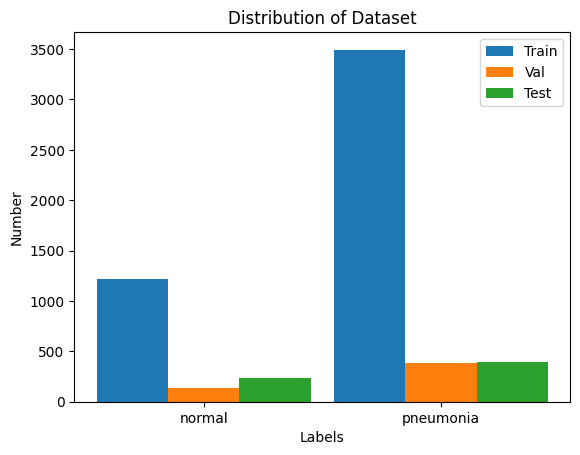

In [ ]:
import matplotlib.pyplot as plt

bar_width = 0.3
index_train = np.arange(2)
index_val,index_test = index_train+bar_width,index_train+2*bar_width
plt.bar(index_train,l_train,width=bar_width,label='Train')
plt.bar(index_val,l_val,width=bar_width,label='Val')
plt.bar(index_test,l_test,width=bar_width,label='Test')
plt.title("Distribution of Dataset")
plt.legend()
plt.xticks(index_val, ['normal','pneumonia'])
plt.xlabel('Labels')
plt.ylabel('Number')
plt.show()

##### IR = pneumonia/normal = 3494/1214 = 2.8780 > 1.5 ==> imbalanced

#### 2. Preprocessing and Augmentation
* Horizon Flipping
* Zoom Range
* Random Rotation

In [ ]:
# preprocessing
data_transform1 = transforms.Compose([
    # transforms.Resize(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-20,20)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])
data_transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])
data_transform3 = transforms.Compose([
    # transforms.Resize(224),
    transforms.CenterCrop(20),
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

In [ ]:
root = '/content/drive/MyDrive/Datasets/'
train_dataset1,train_dataset2,train_dataset3 = PneumoniaMNIST(split='train', transform=data_transform1, root=root),PneumoniaMNIST(split='train', transform=data_transform2, root=root),PneumoniaMNIST(split='train', transform=data_transform3, root=root)
val_dataset1,val_dataset2,val_dataset3 = PneumoniaMNIST(split='val', transform=data_transform1, root=root),PneumoniaMNIST(split='val', transform=data_transform2, root=root),PneumoniaMNIST(split='val', transform=data_transform3, root=root)
test_dataset1,test_dataset2,test_dataset3 = PneumoniaMNIST(split='test', transform=data_transform1, root=root),PneumoniaMNIST(split='test', transform=data_transform2, root=root),PneumoniaMNIST(split='test', transform=data_transform3, root=root)

In [ ]:
train_dataset1[0][0].shape

torch.Size([3, 28, 28])

/usr/local/lib/python3.10/dist-packages/medmnist/utils.py:31: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


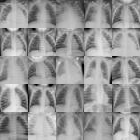

In [ ]:
train_dataset1.montage(5)

In [ ]:
root = '/content/drive/MyDrive/Datasets/'
train_dataset = PneumoniaMNIST(split='train', transform=data_transform, root=root)
val_dataset = PneumoniaMNIST(split='val', transform=data_transform, root=root)
test_dataset = PneumoniaMNIST(split='test', transform=data_transform, root=root)

In [ ]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

#### 3. Model -- Feature extractors and a classifier
* An ensemble of [conv_layer + maxpooling], but dataset is insufficient
* Transfer Learning Method, using pretrained model like Imagenet, Xception（最低维度:71）

In [32]:

# Freeze params of lower layers
class Transfer_resnet(nn.Module):
    def __init__(self, pretrained, in_channels, num_classes):
        super(Transfer_resnet, self).__init__()

        # Use a pretrained model
        self.resnet = pretrained
        for param in self.resnet.parameters():
          param.requires_grad = False

        # Replace model classifier
        self.resnet.fc = nn.Sequential(nn.Linear(2048, 256),
                                       nn.ReLU(),
                                       nn.Linear(256, num_classes))

    def forward(self, x):
        x = self.resnet(x)
        return x

# Fine-tune Resnet50
class Pneumonia_resnet(nn.Module):
    def __init__(self, pretrained, in_channels, num_classes):
        super(Pneumonia_resnet, self).__init__()

        # Use a pretrained model
        self.resnet = pretrained

        # Replace model classifier
        self.resnet.fc = nn.Sequential(nn.Linear(2048, 256),
                                       nn.ReLU(),
                                       nn.Linear(256, num_classes))
        # self.resnet.fc = nn.Linear(2048, num_classes)


    def forward(self, x):
        logits = self.resnet(x)
        return logits

In [ ]:
# Load models defined in Model_A
from drive.MyDrive.A.Model_A import Pneumonia,Transfer_resnet,Pneumonia_resnet

In [ ]:
# define a simple CNN model

model_0 = Pneumonia(in_channels=n_channels, num_classes=n_classes)
model_0

In [33]:
# ResNet50
from torchvision.models import resnet50

pretrained_1 = resnet50(pretrained=True)
model_1 = Pneumonia_resnet(pretrained_1,in_channels=n_channels,num_classes=n_classes)
#model_2 = Transfer_resnet(pretrained_1,in_channels=n_channels,num_classes=n_classes)
model_1


Pneumonia_resnet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

#### 4. Training and Testing

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
SEED = 1234

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [ ]:
BATCH_SIZE = 64
NUM_EPOCHS = 15
lr = 0.0001

train_loader = data.DataLoader(dataset=train_dataset1, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=val_dataset1, batch_size=BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset1, batch_size=BATCH_SIZE, shuffle=False)

In [18]:
# Train
def Train_A(model,train_loader,val_loader,test_loader,NUM_EPOCHS,criterion,optimizer,device):
    model = model.to(device)
    PlotTrainLoss=[]
    PlotValLoss=[]
    BATCH_SIZE = len(train_loader)

    # For each epoch
    for epoch in range(NUM_EPOCHS):
        avg_loss = 0
        train_correct = 0
        all_count = 0

        # Train mode  -->  forward + backward + optimize
        print("-----------------------Epoch{}-----------------------".format(epoch+1))
        model.train()
        for inputs, targets in tqdm(train_loader):
            # Data to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Set parameter gradients to zero
            optimizer.zero_grad()

            # Forward
            outputs = model(inputs)
            targets = targets.squeeze().long()
            # Forward-pass (criterion: loss function, such as CrossEntropyLoss)
            loss = criterion(outputs, targets)

            # Backward-pass
            loss.backward()

            # Update weights
            optimizer.step()

            avg_loss += loss.item()

            # Compute ACC of Training_set
            outputs = torch.argmax(outputs.softmax(dim=-1),dim=1)
            all_count += len(targets)
            correct = len(targets)-torch.count_nonzero(outputs-targets)
            train_correct += correct

        # Compute ACC of Training_set
        acc_train = train_correct/all_count
        print("Training Accuracy: ",acc_train)
        # Compute Loss (sum(loss)/batch_size)
        avg_loss = avg_loss/BATCH_SIZE
        # Test on validation_set
        avg_loss_val = test_A(model,device,'val',val_loader)

        PlotTrainLoss.append(avg_loss)
        PlotValLoss.append(avg_loss_val)

        test_A(model,device,'test',test_loader)

    return PlotTrainLoss,PlotValLoss


# Plot
def plot_loss(NUM_EPOCHS,PlotTrainLoss,PlotValLoss):
    plt.plot(range(1,NUM_EPOCHS+1),PlotTrainLoss,label='TrainLoss')
    plt.plot(range(1,NUM_EPOCHS+1), PlotValLoss, label='ValLoss')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

In [19]:
# Test
def test_A(model,device,split,data_loader):
    testLoss=0
    model.eval()
    y_true = torch.tensor([])       # the ground truth labels
    y_score = torch.tensor([])      # the predicted score of each class

    # To device
    y_true = y_true.to(device)
    y_score = y_score.to(device)

    evaluator = Evaluator('pneumoniamnist', split,root='/content/drive/MyDrive/Datasets/')
    if split == 'val':
        criterion = nn.CrossEntropyLoss()
        with torch.no_grad():
            for inputs, targets in data_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)

                targets = targets.squeeze().long()
                batch_loss = criterion(outputs, targets)
                testLoss += batch_loss.item()/len(data_loader)

                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

                y_true = torch.cat((y_true, targets), 0)
                y_score = torch.cat((y_score, outputs), 0)

            y_true = y_true.cpu().numpy()
            y_score = y_score.detach().cpu().numpy()

            metrics = evaluator.evaluate(y_score)

            print('%s  auc: %.3f  acc:%.3f' % ('val', *metrics))
            return testLoss

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            targets = targets.squeeze().long()

            outputs = outputs.softmax(dim=-1)
            targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.cpu().numpy()
        y_score = y_score.detach().cpu().numpy()

        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % ('test', *metrics))

In [20]:
criterion = nn.CrossEntropyLoss()

In [34]:
# Fine-tune
model1 = model_1
optimizer = optim.Adam(model1.parameters(), lr=0.0001)
TrainLoss1,ValLoss1 = Train_A(model1,train_loader,train_loader_at_eval,test_loader,15,criterion,optimizer,device)

-----------------------Epoch1-----------------------


100%|██████████| 74/74 [00:06<00:00, 11.99it/s]


Training Accuracy:  tensor(0.8813, device='cuda:0')
val  auc: 0.977  acc:0.933
test  auc: 0.925  acc:0.872
-----------------------Epoch2-----------------------


100%|██████████| 74/74 [00:05<00:00, 14.31it/s]


Training Accuracy:  tensor(0.9437, device='cuda:0')
val  auc: 0.986  acc:0.931
test  auc: 0.956  acc:0.875
-----------------------Epoch3-----------------------


100%|██████████| 74/74 [00:05<00:00, 14.59it/s]


Training Accuracy:  tensor(0.9503, device='cuda:0')
val  auc: 0.987  acc:0.950
test  auc: 0.918  acc:0.824
-----------------------Epoch4-----------------------


100%|██████████| 74/74 [00:05<00:00, 12.96it/s]


Training Accuracy:  tensor(0.9603, device='cuda:0')
val  auc: 0.991  acc:0.958
test  auc: 0.953  acc:0.886
-----------------------Epoch5-----------------------


100%|██████████| 74/74 [00:05<00:00, 14.67it/s]


Training Accuracy:  tensor(0.9652, device='cuda:0')
val  auc: 0.994  acc:0.954
test  auc: 0.955  acc:0.885
-----------------------Epoch6-----------------------


100%|██████████| 74/74 [00:05<00:00, 12.62it/s]


Training Accuracy:  tensor(0.9692, device='cuda:0')
val  auc: 0.995  acc:0.975
test  auc: 0.964  acc:0.870
-----------------------Epoch7-----------------------


100%|██████████| 74/74 [00:05<00:00, 14.70it/s]


Training Accuracy:  tensor(0.9688, device='cuda:0')
val  auc: 0.995  acc:0.962
test  auc: 0.966  acc:0.862
-----------------------Epoch8-----------------------


100%|██████████| 74/74 [00:05<00:00, 13.61it/s]


Training Accuracy:  tensor(0.9705, device='cuda:0')
val  auc: 0.995  acc:0.969
test  auc: 0.962  acc:0.857
-----------------------Epoch9-----------------------


100%|██████████| 74/74 [00:05<00:00, 13.91it/s]


Training Accuracy:  tensor(0.9745, device='cuda:0')
val  auc: 0.994  acc:0.964
test  auc: 0.962  acc:0.883
-----------------------Epoch10-----------------------


100%|██████████| 74/74 [00:04<00:00, 14.82it/s]


Training Accuracy:  tensor(0.9692, device='cuda:0')
val  auc: 0.997  acc:0.973
test  auc: 0.949  acc:0.856
-----------------------Epoch11-----------------------


100%|██████████| 74/74 [00:05<00:00, 12.71it/s]


Training Accuracy:  tensor(0.9741, device='cuda:0')
val  auc: 0.996  acc:0.983
test  auc: 0.961  acc:0.837
-----------------------Epoch12-----------------------


100%|██████████| 74/74 [00:04<00:00, 14.87it/s]


Training Accuracy:  tensor(0.9754, device='cuda:0')
val  auc: 0.994  acc:0.969
test  auc: 0.960  acc:0.877
-----------------------Epoch13-----------------------


100%|██████████| 74/74 [00:05<00:00, 12.64it/s]


Training Accuracy:  tensor(0.9773, device='cuda:0')
val  auc: 0.995  acc:0.960
test  auc: 0.957  acc:0.877
-----------------------Epoch14-----------------------


100%|██████████| 74/74 [00:05<00:00, 14.64it/s]


Training Accuracy:  tensor(0.9705, device='cuda:0')
val  auc: 0.996  acc:0.966
test  auc: 0.947  acc:0.891
-----------------------Epoch15-----------------------


100%|██████████| 74/74 [00:05<00:00, 13.70it/s]


Training Accuracy:  tensor(0.9796, device='cuda:0')
val  auc: 0.996  acc:0.969
test  auc: 0.948  acc:0.835


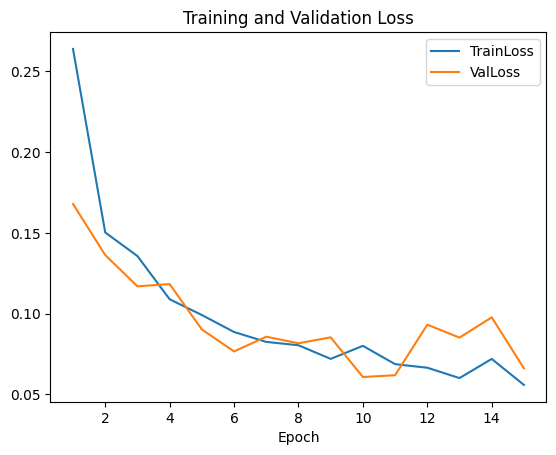

In [35]:
plot_loss(15,TrainLoss1,ValLoss1)

In [26]:
for param in model_2.resnet.fc.parameters():
  param.requires_grad = True
model2 = model_2
optimizer = optim.Adam(model2.resnet.fc.parameters(), lr=0.0001)
TrainLoss2,ValLoss2 = Train_A(model2,train_loader,train_loader_at_eval,test_loader,15,criterion,optimizer,device)

-----------------------Epoch1-----------------------


100%|██████████| 74/74 [00:03<00:00, 18.74it/s]


Training Accuracy:  tensor(0.8579, device='cuda:0')
val  auc: 0.913  acc:0.853
test  auc: 0.867  acc:0.788
-----------------------Epoch2-----------------------


100%|██████████| 74/74 [00:03<00:00, 22.96it/s]


Training Accuracy:  tensor(0.8598, device='cuda:0')
val  auc: 0.908  acc:0.859
test  auc: 0.859  acc:0.748
-----------------------Epoch3-----------------------


100%|██████████| 74/74 [00:03<00:00, 19.05it/s]


Training Accuracy:  tensor(0.8647, device='cuda:0')
val  auc: 0.905  acc:0.851
test  auc: 0.863  acc:0.788
-----------------------Epoch4-----------------------


100%|██████████| 74/74 [00:03<00:00, 21.73it/s]


Training Accuracy:  tensor(0.8636, device='cuda:0')
val  auc: 0.921  acc:0.878
test  auc: 0.867  acc:0.777
-----------------------Epoch5-----------------------


100%|██████████| 74/74 [00:03<00:00, 23.43it/s]


Training Accuracy:  tensor(0.8630, device='cuda:0')
val  auc: 0.933  acc:0.868
test  auc: 0.856  acc:0.758
-----------------------Epoch6-----------------------


100%|██████████| 74/74 [00:03<00:00, 21.12it/s]


Training Accuracy:  tensor(0.8649, device='cuda:0')
val  auc: 0.911  acc:0.868
test  auc: 0.858  acc:0.782
-----------------------Epoch7-----------------------


100%|██████████| 74/74 [00:03<00:00, 19.50it/s]


Training Accuracy:  tensor(0.8632, device='cuda:0')
val  auc: 0.912  acc:0.851
test  auc: 0.851  acc:0.745
-----------------------Epoch8-----------------------


100%|██████████| 74/74 [00:03<00:00, 23.64it/s]


Training Accuracy:  tensor(0.8638, device='cuda:0')
val  auc: 0.925  acc:0.866
test  auc: 0.875  acc:0.788
-----------------------Epoch9-----------------------


100%|██████████| 74/74 [00:03<00:00, 23.02it/s]


Training Accuracy:  tensor(0.8560, device='cuda:0')
val  auc: 0.931  acc:0.866
test  auc: 0.862  acc:0.768
-----------------------Epoch10-----------------------


100%|██████████| 74/74 [00:04<00:00, 17.82it/s]


Training Accuracy:  tensor(0.8675, device='cuda:0')
val  auc: 0.923  acc:0.866
test  auc: 0.867  acc:0.772
-----------------------Epoch11-----------------------


100%|██████████| 74/74 [00:03<00:00, 23.17it/s]


Training Accuracy:  tensor(0.8660, device='cuda:0')
val  auc: 0.929  acc:0.861
test  auc: 0.842  acc:0.753
-----------------------Epoch12-----------------------


100%|██████████| 74/74 [00:03<00:00, 23.42it/s]


Training Accuracy:  tensor(0.8672, device='cuda:0')
val  auc: 0.919  acc:0.874
test  auc: 0.879  acc:0.792
-----------------------Epoch13-----------------------


100%|██████████| 74/74 [00:03<00:00, 21.45it/s]


Training Accuracy:  tensor(0.8717, device='cuda:0')
val  auc: 0.928  acc:0.872
test  auc: 0.875  acc:0.776
-----------------------Epoch14-----------------------


100%|██████████| 74/74 [00:03<00:00, 19.99it/s]


Training Accuracy:  tensor(0.8651, device='cuda:0')
val  auc: 0.914  acc:0.855
test  auc: 0.872  acc:0.785
-----------------------Epoch15-----------------------


100%|██████████| 74/74 [00:03<00:00, 23.36it/s]


Training Accuracy:  tensor(0.8700, device='cuda:0')
val  auc: 0.942  acc:0.901
test  auc: 0.870  acc:0.785


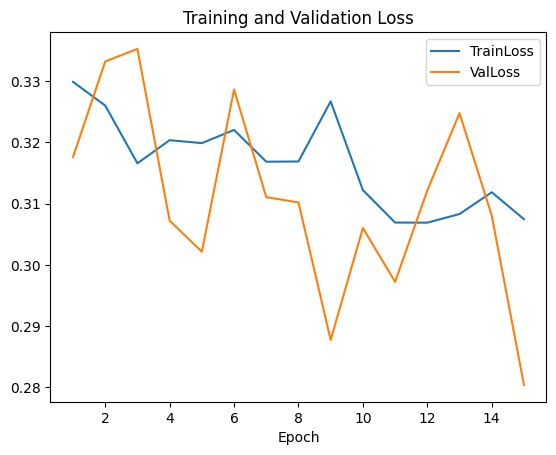

In [27]:
plot_loss(15,TrainLoss2,ValLoss2)

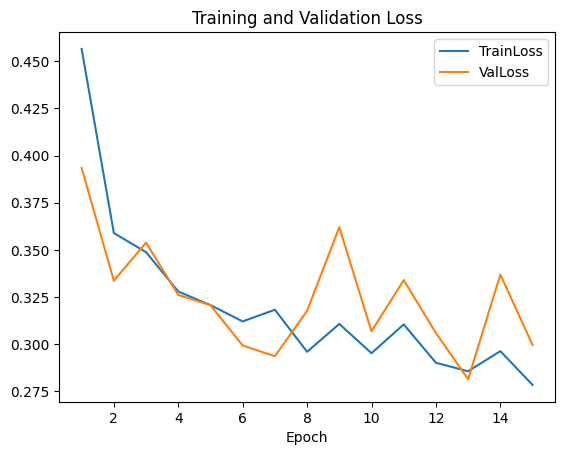

In [ ]:
plot_loss(15,TrainLoss2,ValLoss2)

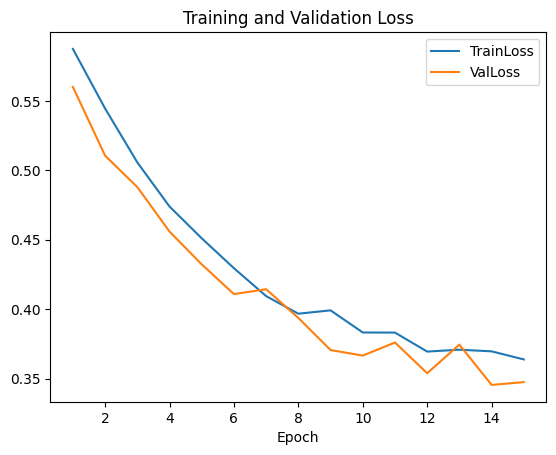

In [ ]:
plot_loss(15,TrainLoss1,ValLoss1)

In [ ]:
# Simple CNN
model = model_0
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# Define the loss function
criterion = nn.CrossEntropyLoss()
TrainLoss,ValLoss = Train_A(model,train_loader,train_loader_at_eval,test_loader,15,criterion,optimizer,device)

-----------------------Epoch1-----------------------


100%|██████████| 74/74 [00:03<00:00, 21.57it/s]


Training Accuracy:  tensor(0.8777, device='cuda:0')
val  auc: 0.982  acc:0.924
test  auc: 0.940  acc:0.800
-----------------------Epoch2-----------------------


100%|██████████| 74/74 [00:02<00:00, 34.43it/s]


Training Accuracy:  tensor(0.9393, device='cuda:0')
val  auc: 0.987  acc:0.952
test  auc: 0.953  acc:0.824
-----------------------Epoch3-----------------------


100%|██████████| 74/74 [00:01<00:00, 38.68it/s]


Training Accuracy:  tensor(0.9518, device='cuda:0')
val  auc: 0.992  acc:0.948
test  auc: 0.948  acc:0.862
-----------------------Epoch4-----------------------


100%|██████████| 74/74 [00:01<00:00, 39.30it/s]


Training Accuracy:  tensor(0.9556, device='cuda:0')
val  auc: 0.993  acc:0.964
test  auc: 0.953  acc:0.854
-----------------------Epoch5-----------------------


100%|██████████| 74/74 [00:01<00:00, 38.75it/s]


Training Accuracy:  tensor(0.9569, device='cuda:0')
val  auc: 0.993  acc:0.958
test  auc: 0.956  acc:0.833
-----------------------Epoch6-----------------------


100%|██████████| 74/74 [00:03<00:00, 20.78it/s]


Training Accuracy:  tensor(0.9613, device='cuda:0')
val  auc: 0.993  acc:0.958
test  auc: 0.956  acc:0.856
-----------------------Epoch7-----------------------


100%|██████████| 74/74 [00:02<00:00, 29.85it/s]


Training Accuracy:  tensor(0.9643, device='cuda:0')
val  auc: 0.994  acc:0.966
test  auc: 0.957  acc:0.856
-----------------------Epoch8-----------------------


100%|██████████| 74/74 [00:01<00:00, 38.44it/s]


Training Accuracy:  tensor(0.9656, device='cuda:0')
val  auc: 0.993  acc:0.968
test  auc: 0.958  acc:0.837
-----------------------Epoch9-----------------------


100%|██████████| 74/74 [00:01<00:00, 38.37it/s]


Training Accuracy:  tensor(0.9677, device='cuda:0')
val  auc: 0.994  acc:0.969
test  auc: 0.963  acc:0.833
-----------------------Epoch10-----------------------


100%|██████████| 74/74 [00:02<00:00, 28.43it/s]


Training Accuracy:  tensor(0.9667, device='cuda:0')
val  auc: 0.991  acc:0.952
test  auc: 0.961  acc:0.877
-----------------------Epoch11-----------------------


100%|██████████| 74/74 [00:01<00:00, 37.12it/s]


Training Accuracy:  tensor(0.9688, device='cuda:0')
val  auc: 0.993  acc:0.969
test  auc: 0.962  acc:0.853
-----------------------Epoch12-----------------------


100%|██████████| 74/74 [00:02<00:00, 28.87it/s]


Training Accuracy:  tensor(0.9671, device='cuda:0')
val  auc: 0.992  acc:0.966
test  auc: 0.960  acc:0.845
-----------------------Epoch13-----------------------


100%|██████████| 74/74 [00:02<00:00, 35.98it/s]


Training Accuracy:  tensor(0.9718, device='cuda:0')
val  auc: 0.994  acc:0.962
test  auc: 0.962  acc:0.897
-----------------------Epoch14-----------------------


100%|██████████| 74/74 [00:01<00:00, 39.17it/s]


Training Accuracy:  tensor(0.9705, device='cuda:0')
val  auc: 0.995  acc:0.964
test  auc: 0.957  acc:0.817
-----------------------Epoch15-----------------------


100%|██████████| 74/74 [00:01<00:00, 39.05it/s]


Training Accuracy:  tensor(0.9675, device='cuda:0')
val  auc: 0.994  acc:0.973
test  auc: 0.959  acc:0.837


In [ ]:
# Simple CNN
model = model_0
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00001)
# Define the loss function
criterion = nn.CrossEntropyLoss()
TrainLoss,ValLoss = Train_A(model,train_loader,train_loader_at_eval,test_loader,15,criterion,optimizer,device)

-----------------------Epoch1-----------------------


100%|██████████| 74/74 [00:03<00:00, 19.07it/s]


Training Accuracy:  tensor(0.6933, device='cuda:0')
val  auc: 0.815  acc:0.744
test  auc: 0.758  acc:0.627
-----------------------Epoch2-----------------------


100%|██████████| 74/74 [00:01<00:00, 38.29it/s]


Training Accuracy:  tensor(0.7850, device='cuda:0')
val  auc: 0.943  acc:0.817
test  auc: 0.905  acc:0.720
-----------------------Epoch3-----------------------


100%|██████████| 74/74 [00:01<00:00, 37.95it/s]


Training Accuracy:  tensor(0.8774, device='cuda:0')
val  auc: 0.957  acc:0.903
test  auc: 0.930  acc:0.824
-----------------------Epoch4-----------------------


100%|██████████| 74/74 [00:01<00:00, 39.64it/s]


Training Accuracy:  tensor(0.9159, device='cuda:0')
val  auc: 0.970  acc:0.920
test  auc: 0.933  acc:0.840
-----------------------Epoch5-----------------------


100%|██████████| 74/74 [00:01<00:00, 38.67it/s]


Training Accuracy:  tensor(0.9197, device='cuda:0')
val  auc: 0.975  acc:0.929
test  auc: 0.938  acc:0.841
-----------------------Epoch6-----------------------


100%|██████████| 74/74 [00:02<00:00, 30.36it/s]


Training Accuracy:  tensor(0.9350, device='cuda:0')
val  auc: 0.979  acc:0.931
test  auc: 0.940  acc:0.861
-----------------------Epoch7-----------------------


100%|██████████| 74/74 [00:02<00:00, 33.63it/s]


Training Accuracy:  tensor(0.9318, device='cuda:0')
val  auc: 0.978  acc:0.931
test  auc: 0.932  acc:0.846
-----------------------Epoch8-----------------------


100%|██████████| 74/74 [00:01<00:00, 38.97it/s]


Training Accuracy:  tensor(0.9322, device='cuda:0')
val  auc: 0.981  acc:0.929
test  auc: 0.940  acc:0.862
-----------------------Epoch9-----------------------


100%|██████████| 74/74 [00:01<00:00, 38.70it/s]


Training Accuracy:  tensor(0.9373, device='cuda:0')
val  auc: 0.980  acc:0.933
test  auc: 0.945  acc:0.861
-----------------------Epoch10-----------------------


100%|██████████| 74/74 [00:01<00:00, 38.30it/s]


Training Accuracy:  tensor(0.9395, device='cuda:0')
val  auc: 0.982  acc:0.937
test  auc: 0.943  acc:0.845
-----------------------Epoch11-----------------------


100%|██████████| 74/74 [00:02<00:00, 34.36it/s]


Training Accuracy:  tensor(0.9401, device='cuda:0')
val  auc: 0.982  acc:0.933
test  auc: 0.943  acc:0.849
-----------------------Epoch12-----------------------


100%|██████████| 74/74 [00:02<00:00, 29.75it/s]


Training Accuracy:  tensor(0.9422, device='cuda:0')
val  auc: 0.984  acc:0.943
test  auc: 0.941  acc:0.846
-----------------------Epoch13-----------------------


100%|██████████| 74/74 [00:01<00:00, 38.14it/s]


Training Accuracy:  tensor(0.9433, device='cuda:0')
val  auc: 0.984  acc:0.937
test  auc: 0.943  acc:0.848
-----------------------Epoch14-----------------------


100%|██████████| 74/74 [00:01<00:00, 38.89it/s]


Training Accuracy:  tensor(0.9463, device='cuda:0')
val  auc: 0.985  acc:0.931
test  auc: 0.945  acc:0.859
-----------------------Epoch15-----------------------


100%|██████████| 74/74 [00:01<00:00, 39.49it/s]


Training Accuracy:  tensor(0.9463, device='cuda:0')
val  auc: 0.987  acc:0.947
test  auc: 0.941  acc:0.851


In [ ]:
model.to(device)
train_correct = 0
all_count = 0
for x,y in test_loader:
  x = x.to(device)
  y = y.to(device)


  y = y.squeeze().long()
  #print(y)
  out = model(x)
  out = torch.argmax(out.softmax(dim=-1),dim=1)
  #print(out)
  all_count += len(y)
  #print((64-torch.count_nonzero(out-y))/64)
  correct = len(y)-torch.count_nonzero(out-y).item()
  train_correct += correct
  #out = out.cpu().numpy()
  #y = y.cpu().numpy()
acc_train = train_correct/all_count
print(train_correct)
print(all_count)
print(acc_train)

534
624
0.8557692307692307


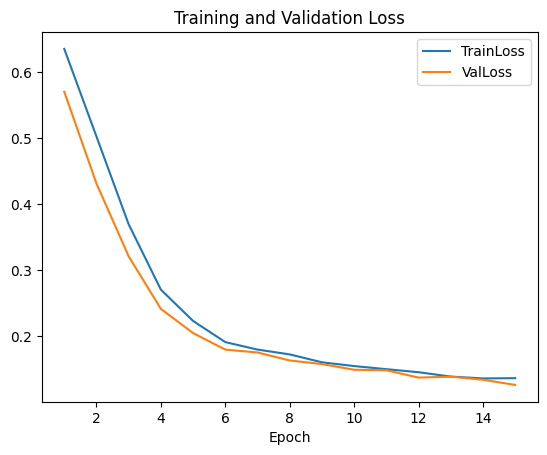

In [ ]:
plot_loss(15,TrainLoss,ValLoss)

In [ ]:
# Finetune ResNet50
model1 = model_1
optimizer = optim.Adam(model1.parameters(), lr=0.00001)
TrainLoss1,ValLoss1 = Train_A(model1,train_loader,train_loader_at_eval,test_loader,15,criterion,optimizer,device)

-----------------------Epoch1-----------------------


100%|██████████| 74/74 [00:05<00:00, 14.15it/s]


Training Accuracy:  tensor(0.7288, device='cuda:0')
val  auc: 0.917  acc:0.861
test  auc: 0.847  acc:0.788
-----------------------Epoch2-----------------------


100%|██████████| 74/74 [00:04<00:00, 16.39it/s]


Training Accuracy:  tensor(0.8864, device='cuda:0')
val  auc: 0.950  acc:0.885
test  auc: 0.886  acc:0.809
-----------------------Epoch3-----------------------


100%|██████████| 74/74 [00:05<00:00, 14.06it/s]


Training Accuracy:  tensor(0.9012, device='cuda:0')
val  auc: 0.966  acc:0.905
test  auc: 0.887  acc:0.784
-----------------------Epoch4-----------------------


100%|██████████| 74/74 [00:04<00:00, 16.46it/s]


Training Accuracy:  tensor(0.9195, device='cuda:0')
val  auc: 0.959  acc:0.905
test  auc: 0.898  acc:0.812
-----------------------Epoch5-----------------------


100%|██████████| 74/74 [00:04<00:00, 15.98it/s]


Training Accuracy:  tensor(0.9269, device='cuda:0')
val  auc: 0.965  acc:0.922
test  auc: 0.900  acc:0.806
-----------------------Epoch6-----------------------


100%|██████████| 74/74 [00:05<00:00, 14.79it/s]


Training Accuracy:  tensor(0.9359, device='cuda:0')
val  auc: 0.973  acc:0.939
test  auc: 0.919  acc:0.824
-----------------------Epoch7-----------------------


100%|██████████| 74/74 [00:04<00:00, 16.54it/s]


Training Accuracy:  tensor(0.9329, device='cuda:0')
val  auc: 0.973  acc:0.941
test  auc: 0.917  acc:0.812
-----------------------Epoch8-----------------------


100%|██████████| 74/74 [00:04<00:00, 15.07it/s]


Training Accuracy:  tensor(0.9367, device='cuda:0')
val  auc: 0.976  acc:0.943
test  auc: 0.924  acc:0.811
-----------------------Epoch9-----------------------


100%|██████████| 74/74 [00:04<00:00, 16.00it/s]


Training Accuracy:  tensor(0.9354, device='cuda:0')
val  auc: 0.982  acc:0.935
test  auc: 0.926  acc:0.819
-----------------------Epoch10-----------------------


100%|██████████| 74/74 [00:04<00:00, 16.81it/s]


Training Accuracy:  tensor(0.9410, device='cuda:0')
val  auc: 0.984  acc:0.939
test  auc: 0.911  acc:0.819
-----------------------Epoch11-----------------------


100%|██████████| 74/74 [00:05<00:00, 14.35it/s]


Training Accuracy:  tensor(0.9469, device='cuda:0')
val  auc: 0.981  acc:0.945
test  auc: 0.936  acc:0.825
-----------------------Epoch12-----------------------


100%|██████████| 74/74 [00:04<00:00, 16.80it/s]


Training Accuracy:  tensor(0.9545, device='cuda:0')
val  auc: 0.985  acc:0.947
test  auc: 0.935  acc:0.827
-----------------------Epoch13-----------------------


100%|██████████| 74/74 [00:04<00:00, 16.88it/s]


Training Accuracy:  tensor(0.9456, device='cuda:0')
val  auc: 0.983  acc:0.950
test  auc: 0.931  acc:0.833
-----------------------Epoch14-----------------------


100%|██████████| 74/74 [00:05<00:00, 14.59it/s]


Training Accuracy:  tensor(0.9528, device='cuda:0')
val  auc: 0.984  acc:0.941
test  auc: 0.936  acc:0.825
-----------------------Epoch15-----------------------


100%|██████████| 74/74 [00:04<00:00, 16.70it/s]


Training Accuracy:  tensor(0.9490, device='cuda:0')
val  auc: 0.984  acc:0.947
test  auc: 0.938  acc:0.827


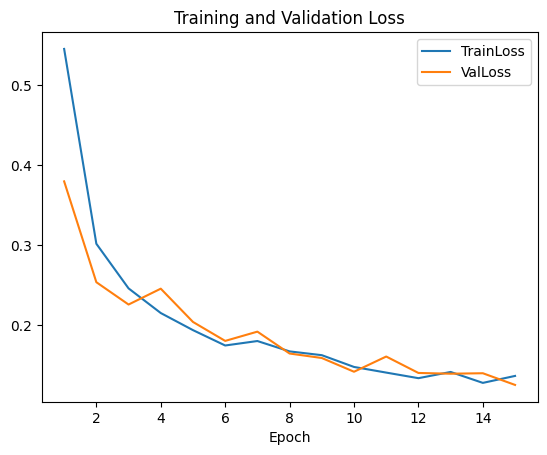

In [ ]:
plot_loss(15,TrainLoss1,ValLoss1)

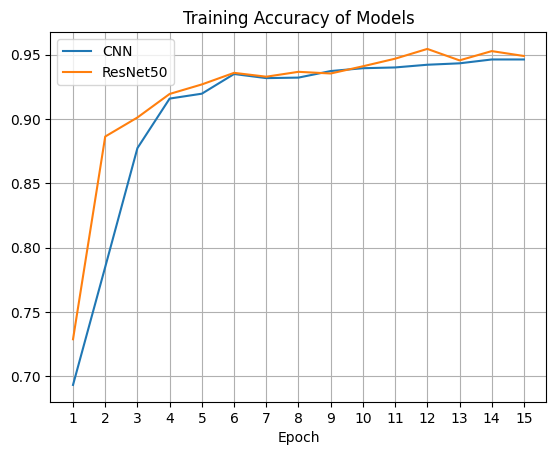

In [ ]:
# Plot Accuracy
ACC_cnn=[0.6933,0.7850,0.8774,0.9159,0.9197,0.9350,0.9318,0.9322,0.9373,0.9395,0.9401,0.9422,0.9433,0.9463,0.9463]

ACC_res=[0.7288,0.8864,0.9012,0.9195,0.9269,0.9359,0.9329,0.9367,0.9354,0.9410,0.9469,0.9545,0.9456,0.9528,0.9490]

plt.plot(range(1,NUM_EPOCHS+1),ACC_cnn)
plt.plot(range(1,NUM_EPOCHS+1),ACC_res)

plt.legend(['CNN','ResNet50'])
plt.title("Training Accuracy of Models")
plt.xlabel("Epoch")
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.grid()
plt.show()

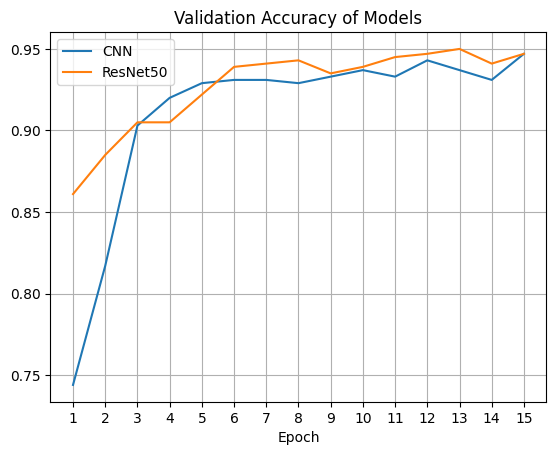

In [ ]:
val_cnn=[0.744,0.817,0.903,0.920,0.929,0.931,0.931,0.929,0.933,0.937,0.933,0.943,0.937,0.931,0.947]
val_res=[0.861,0.885,0.905,0.905,0.922,0.939,0.941,0.943,0.935,0.939,0.945,0.947,0.950,0.941,0.947]
plt.plot(range(1,NUM_EPOCHS+1),val_cnn)
plt.plot(range(1,NUM_EPOCHS+1),val_res)
plt.legend(['CNN','ResNet50'])
plt.title("Validation Accuracy of Models")
plt.xlabel("Epoch")
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.grid()
plt.show()